In [144]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [431]:
import cv2
import numpy as np
import os
import scipy.io as io
import matplotlib.pyplot as plt
import pickle

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import layers

import random
from tqdm import tqdm
from scipy.spatial.transform import Rotation

from custom_data_manager import AugmentationManager
from custom_data_manager import CustomDataCollector
from custom_data_manager import CustomDataLoader
from custom_data_manager import DataGeneratorBuilder
from model_manager import ModelManager

from utils import *

In [139]:
IMG_SIZE=96

## Prepare

In [326]:
#Takes long time
custom_ycb_path = "C:\\Users\\mati\\Desktop\\Moje\\dyplomowa\\datasets\\ycb_video_sicrod"

sub_dirs_to_load = ['0006', '0009', '0010', '0012', '0018', '0024', 
                    '0030', '0038','0050','0056','0059','0077','0081',
                    '0083','0086','0088','0011', '0037', '0054']

sub_dirs_to_load = ['0010', '0012', '0018', '0077', '0081']

train_types = ['0010', '0018', '0077']
val_types = ['0012','0081']

In [ ]:
data_collector = CustomDataCollector(IMG_SIZE, sub_dirs_to_load, custom_ycb_path)
data_collector.collect()
frames_poses_dict = data_collector.frames_poses_dict

In [166]:
aug_pipeline = [
        {"aug_type": "channel_shift", "parameters": []},
        {"aug_type": "rotation", "parameters": [50]},
        {"aug_type": "flip", "parameters": []},
        {"aug_type": "random_rectangles", "parameters": [10, 0.2, True]},
    ]

augmentator = AugmentationManager(aug_pipeline)

In [167]:
data_loader = CustomDataLoader(IMG_SIZE,augmentator)

## Generators

In [419]:
train_generator_builder = DataGeneratorBuilder(data_loader, frames_poses_dict, train_types, aug = True)
train_generator = train_generator_builder.generator
tf_train_generator = train_generator_builder.build_tf_generator()

val_generator_builder = DataGeneratorBuilder(data_loader, frames_poses_dict, val_types, aug = False)
val_generator = val_generator_builder.generator
tf_val_generator = val_generator_builder.build_tf_generator()

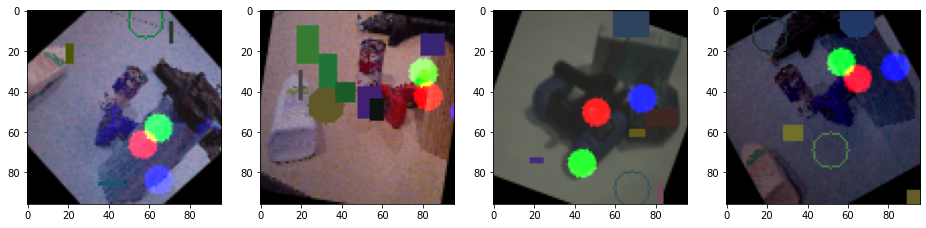

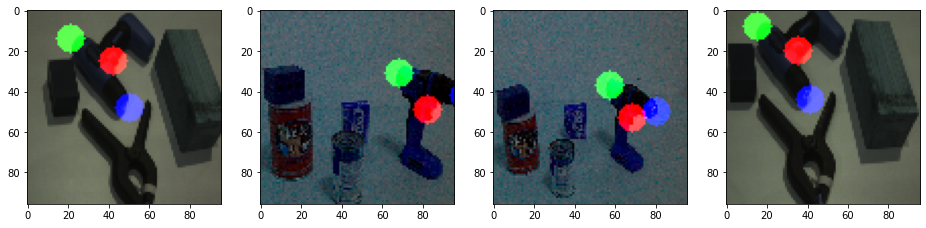

In [428]:
visualize_image_data(train_generator)
visualize_image_data(val_generator)

## Define Model

In [738]:
config = {}
model_manager = ModelManager(config)
model = model_manager.build_model(IMG_SIZE)

In [739]:
#model.summary()

In [740]:
def get_generator_images(generator, probes):
    images = []
    for _ in range(probes):
        frame, mask = next(generator)
        images.append(frame)
    return images

In [741]:
train_images = get_generator_images(train_generator, 9)
val_images = get_generator_images(val_generator, 9)

In [742]:
def save_plots(train_history, experiment_path):

    met0 = [x[0] for x in train_history]
    met1 = [x[1] for x in train_history]
    met2 = [x[2] for x in train_history]
    met3 = [x[3] for x in train_history]
    
    plt.plot(met0, label='train')
    plt.plot(met1, label='val')
    plt.legend(loc='best')
    plt.xlabel("Epochs")
    plt.ylabel("OKS metrics %")
    plt.grid()
    plt.savefig(os.path.join(experiment_path,'books_oks.png'))
    plt.close()

    plt.plot(met2, label='train')
    plt.plot(met3, label='val')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.grid()
    plt.savefig(os.path.join(experiment_path,'books_loss.png'))
    plt.close()


        
def save_predicted_masks(model, train_images, val_images, experiment_train_images_path, experiment_val_images_path):
    train_images = np.array(train_images)
    val_images = np.array(val_images)
    train_predicted_masks = model.predict(train_images)
    val_predicted_masks = model.predict(val_images)
    
    fig = plt.figure(figsize=(12, 12))
    rows = 3
    columns = 3

    for i in range(9):
        img = train_images[i]
        mask = train_predicted_masks[i]
        fig.add_subplot(rows, columns, i+1)
        img_to_visualize = img/3+mask[:,:,0:3]
        img_to_visualize = np.clip(img_to_visualize, 0, 1)
        plt.imshow(img_to_visualize)
    fig.savefig(experiment_train_images_path)
    plt.close() 
    
    fig = plt.figure(figsize=(12, 12))
    rows = 3
    columns = 3
    for i in range(9):
        img = val_images[i]
        mask = val_predicted_masks[i]
        fig.add_subplot(rows, columns, i+1)
        img_to_visualize = img/3+mask[:,:,0:3]
        img_to_visualize = np.clip(img_to_visualize, 0, 1)
        plt.imshow(img_to_visualize)
    fig.savefig(experiment_val_images_path)
    plt.close() 

def save_results(train_history,model, train_images, val_images, epoch, experiment_name):

    
    results_path = "C:\\Users\\mati\\Desktop\\Moje\\dyplomowa\\repo\\Pose-estimation-hourglass\\rgbd_ycb\\results"
    experiment_path = os.path.join(results_path, experiment_name)
    experiment_train_images_path = os.path.join(results_path, experiment_name, "train_images")
    experiment_val_images_path = os.path.join(results_path, experiment_name, "val_images")
    if not os.path.exists(experiment_path):
        os.makedirs(experiment_path)
    if not os.path.exists(experiment_train_images_path):
        os.makedirs(experiment_train_images_path)
    if not os.path.exists(experiment_val_images_path):
        os.makedirs(experiment_val_images_path)
    
    experiment_train_images_path = os.path.join(experiment_train_images_path,f"epoch_{epoch}.png")
    experiment_val_images_path = os.path.join(experiment_val_images_path,f"epoch_{epoch}.png")
    save_plots(train_history, experiment_path)
    save_predicted_masks(model, 
                         train_images, 
                         val_images, 
                         experiment_train_images_path, 
                         experiment_val_images_path)
    


In [743]:
train_history = []

In [744]:
m_calc = MetricsCalculator()
m_calc.calc_oks_metric(model,val_generator, 100)

class my_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_oks = m_calc.calc_oks_metric(model,train_generator, 100)*100/IMG_SIZE
        val_oks = m_calc.calc_oks_metric(model,val_generator, 100)*100/IMG_SIZE
        train_loss = logs.get("loss")
        val_loss = model.evaluate(tf_val_generator)
        train_history.append((train_oks,val_oks,train_loss,val_loss))
        print()
        print("train_oks:", train_oks, "val_oks:",val_oks)
        save_results(train_history,model, train_images, val_images, epoch, "ycb_train_5_dev_3_simple")
        return None

## Train

In [745]:
opt = tf.keras.optimizers.Adam(learning_rate=0.003)
model.compile(optimizer=opt, loss = "mse")

In [ ]:
model.fit(tf_train_generator, 
            #validation_data = tf_val_generator,  
            epochs = 100, batch_size = 16,
           callbacks=[my_callback()]
           )

Epoch 1/100
130/130 [==============================] - 4s 27ms/step - loss: 0.0154

train_oks: 24.08782750986765 val_oks: 33.73834369910483
256/256 [==============================] - 22s 77ms/step - loss: 0.0223
Epoch 2/100
130/130 [==============================] - 3s 26ms/step - loss: 0.0153

train_oks: 23.36964006935337 val_oks: 26.36719230888912
256/256 [==============================] - 19s 74ms/step - loss: 0.0143
Epoch 3/100
130/130 [==============================] - 3s 26ms/step - loss: 0.0149

train_oks: 21.649769909308464 val_oks: 23.17993212726769
256/256 [==============================] - 19s 75ms/step - loss: 0.0140
Epoch 4/100
130/130 [==============================] - 3s 26ms/step - loss: 0.0150

train_oks: 20.160636827888066 val_oks: 23.019871510951393
256/256 [==============================] - 20s 78ms/step - loss: 0.0136
Epoch 5/100
130/130 [==============================] - 3s 26ms/step - loss: 0.0149

train_oks: 15.498048164731976 val_oks: 23.88595668243234
256/256 

## Evaulate